In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import mat73
import scipy.io as sio
import sys
from timeit import default_timer as timer
import plotly
import plotly.graph_objs as go
from matplotlib import pyplot as plt, cm
from matplotlib import colors
import open3d as o3d
from torch import nn
np.set_printoptions(threshold=sys.maxsize)

from utilsReal.optim import Model, training_loop, bruteForce
from utilsReal.generateBasis import generateBasisFunction
from utilsReal.helper import computeVisibility3D, pulse, lowPassFilter
from utilsReal.shape import carving

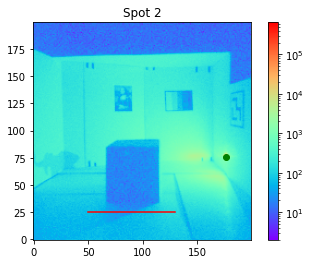

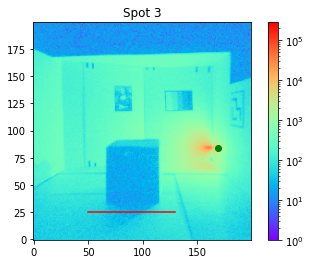

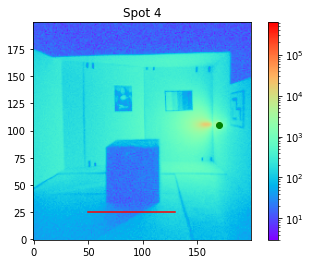

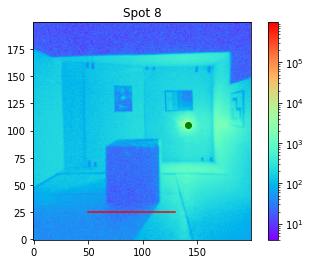

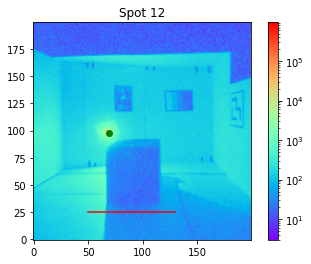

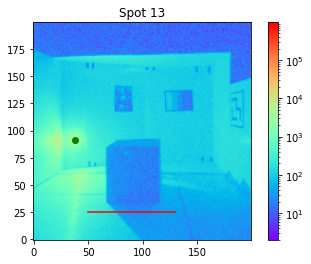

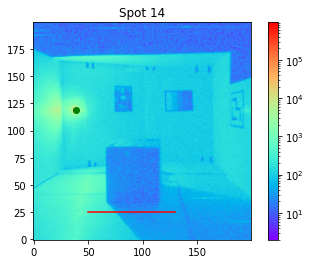

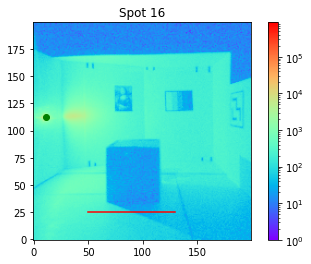

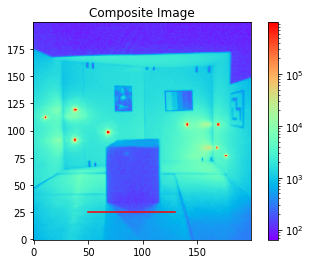

In [2]:
#####################################################################
####################### IMPORT TIME PROFILES ########################
#####################################################################

# data parameters
bin_width = 8E-12
t0 = 14.2428e-9; bin0 = round(t0 / bin_width)
numBins = 8192 - bin0
t = np.linspace(0, bin_width * (numBins-1), numBins)

# plot parameters
plotImgs = True

# detector parameters
num_u = 200; num_v = 200 # dimension of video
y = 25; x_min = 50; x_max = 130 
nc = np.array([0, 0, 1])

numPixels = x_max - x_min + 1
x_line = np.linspace(x_min, x_max, numPixels); y_line = y * np.ones(numPixels)
det_locs = np.hstack((np.reshape(x_line, (numPixels, 1)), np.reshape(y_line, (numPixels, 1)))).astype(int)

# laser parameters
# spots = [1, 2, 3, 4, 6, 7, 9, 11, 14, 16];
# spots = [4, 6, 7, 9, 11, 14, 16];
# spots = [4, 6, 7, 9, 16];
spots = np.array([i for i in range(1, 17)])
# removeSpots = np.array([6, 7, 9, 10, 11, 15]) - 1
removeSpots = np.array([1, 5, 6, 7, 9, 10, 11, 15]) - 1
las_locs = sio.loadmat('../../data/IBO_Collection/spotLocs.mat')['spot_locs'].astype(int)

spots = np.delete(spots, removeSpots)
las_locs = np.delete(las_locs, removeSpots, axis=0)
las_locs[:, 1] = num_v - 1 - las_locs[:, 1]
numSpots = len(spots);

# Import pulse
filename = '../../data/Bounce Flash/replica.mat'
pulseShape = np.squeeze(sio.loadmat(filename)['replica'])[bin0:]
pulseShape = np.roll(pulseShape, 50-np.argmax(pulseShape))
# pulseShape = pulseShape / np.max(pulseShape)

# import histograms for relevant pixels
indiv_hists = np.zeros((numPixels, numSpots, numBins)) # pixels 99-154
observation = np.zeros((num_v, num_u, numBins))
for i in range(numSpots):
    num = str(spots[i])
    filename = '../../data/IBO_Collection/spot_' + num + '.mat'
    dataCube = mat73.loadmat(filename)['dataCube']
    dataCube_r = np.reshape(dataCube[:, bin0:], (num_v, num_u, numBins))
    
    indiv_hists[:, i, :] = np.squeeze(dataCube_r[y, x_min:x_max+1, :])
    observation += dataCube_r 
    
    # plot time-integrated images
    if plotImgs:
        plt.figure(); plt.title('Spot ' + str(spots[i]))
        t_int = np.sum(dataCube_r, 2)
        im = plt.imshow(t_int, cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
        plt.colorbar(im)
        # plot detector locations
        plt.plot(x_line, y_line, 'r')
        
        # plot laser locations
        plt.plot(las_locs[i, 0], las_locs[i, 1], 'og')
        plt.show()

# indiv_hists2 = lowPassFilter(t, indiv_hists, bin_width, 0.7E10, False)
observations = np.sum(indiv_hists, axis=1)

# plot superimposed image
plt.figure(); plt.title('Composite Image')
im = plt.imshow(np.sum(observation, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
plt.colorbar(im)
plt.plot(x_line, y_line, 'r')
plt.show()

In [3]:
#####################################################################
################### IMPORT GT PHYSICAL PARAMETERS ###################
#####################################################################

# import gt tofs
gt_2b = sio.loadmat('../../data/IBO_Collection/2b_travel_time.mat')['t2']
gt_2b = np.delete(gt_2b, removeSpots, axis=0)
gt_2b = np.reshape(gt_2b, (numSpots, num_v, num_u))
tofs = np.zeros((numPixels, numSpots))
for i in range(numSpots):
    tofs[:, i] = gt_2b[i, det_locs[:, 1], det_locs[:, 0]]

# Import depth, surface normal, and albedo data
filename = '../../data/Bounce Flash/scene.mat'

n_vector = sio.loadmat(filename)['n_p']
n_vector = np.reshape(n_vector, (num_v, num_u, 3))

albedo = np.squeeze(sio.loadmat(filename)['rho2_est'])
albedo = np.reshape(albedo, (num_v, num_u))

pt_loc_v = sio.loadmat(filename)['x_p']
pt_loc = np.reshape(pt_loc_v, (num_v, num_u, 3))

# Save x, y, z data to .ply file if needed
if False:
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pt_loc_v)
    o3d.io.write_point_cloud("../../data/Bounce Flash/sync.ply", pcd)

# Visualize point cloud (WARNING: This will open another window and you will be forced to kill kernal)
if False:
    cloud = o3d.io.read_point_cloud("../../data/Bounce Flash/sync.ply") # Read the point cloud
    o3d.visualization.draw_geometries([cloud])

# specify GT visibility matrix
vis_gt = np.zeros((numPixels, numSpots))
vis_gt[41:, 0] = 1 # spot 2
vis_gt[51:, 1] = 1 # spot 3
vis_gt[49:, 2] = 1 # spot 4
vis_gt[58:, 3] = 1 # spot 8
vis_gt[0:16, 4] = 1 # spot 12
vis_gt[0:27, 5] = 1 # spot 13
vis_gt[0:31, 6] = 1 # spot 14
vis_gt[0:42, 7] = 1 # spot 16

Original: 2.0284285303466343e-16
Filter: 0.1311884220415096


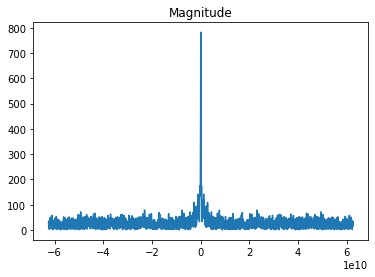

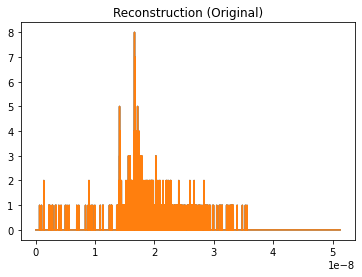

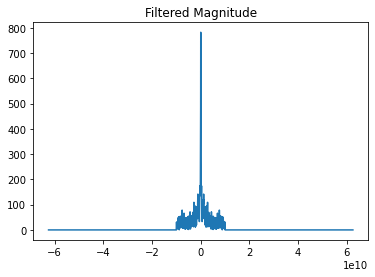

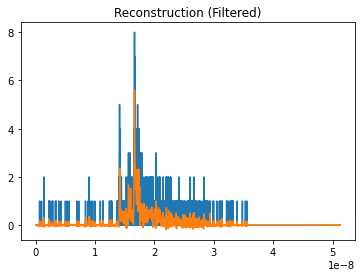

In [23]:
#####################################################################
########################### FILTERED SIGNAL #########################
#####################################################################
a = pulseShape
pixNumb = -1
a = observations[pixNumb, :]
# a = indiv_hists[0, 5, :]
reconst_filt = lowPassFilter(t, a, bin_width, 1E10, True)

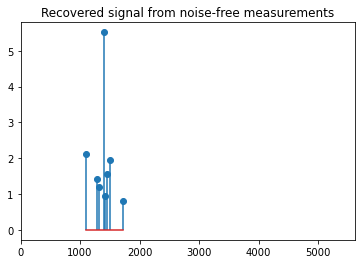

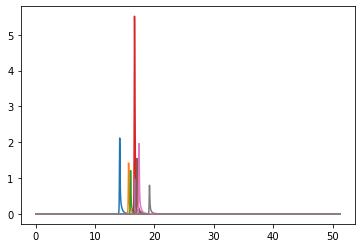

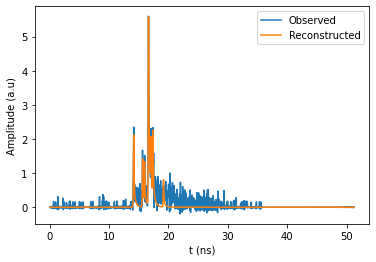

In [24]:
#####################################################################
###################### DETERMINE 2-BOUNCE TOFs ######################
#####################################################################
from sklearn.linear_model import OrthogonalMatchingPursuit

# construct dictionary matrix P
t_min = 5; t_max = 50 # in nanoseconds
L = 1 + int((t_max - t_min) / (bin_width * 1E9))
shifts = 1E-9 * np.linspace(t_min, t_max, L)
P = np.zeros((numBins, L))
for i in range(L):
    a = np.roll(pulseShape, round(shifts[i] / bin_width))
    P[:, i] = np.array(a) / np.max(a)
    
# compute K-sparse representation
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=numSpots, normalize=False)
# observation = observations[-1, :]
observation = reconst_filt
omp.fit(P, observation)

# plot sparse recovery
coef = omp.coef_
(idx_r,) = coef.nonzero()
tof_preds = shifts[idx_r]
plt.figure()
plt.xlim(0, L)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

# plot reconstructed sparse signal
plt.figure()
reconst = np.zeros(numBins)
t0 = 0; t1 = -1; t_val = t[t0:t1]; 
for i in idx_r:
    if coef[i] > -60000:
        reconst += coef[i] * P[:, i]
        plt.plot(1E9*t_val, coef[i] * P[t0:t1, i])
plt.figure()
plt.plot(1E9*t_val, observation[t0:t1])
plt.plot(1E9*t_val, reconst[t0:t1])
plt.xlabel('t (ns)')
plt.ylabel('Amplitude (a.u)')
plt.legend(['Observed', 'Reconstructed'])

--------------------------------------------------
GT
[1.41430631e-08 1.59187820e-08 1.56678181e-08 1.66568778e-08]
--------------------------------------------------
estimated
[1.6232e-08 1.3736e-08 1.6984e-08 1.6640e-08 1.5232e-08 1.5568e-08
 1.6408e-08 1.8752e-08]
--------------------------------------------------
Weights
[5.51717283 2.11862267 1.96372137 1.54695566 1.41967348 1.20959693
 0.95416023 0.79959841]


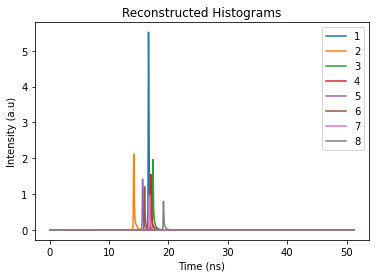

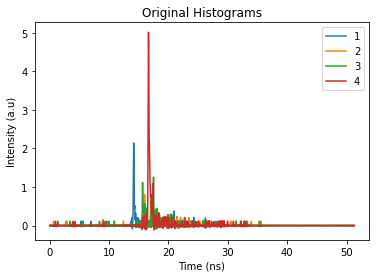

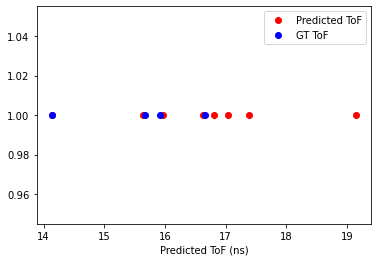

In [31]:
idx_r_sort = np.flip(np.argsort(coef))[0:numSpots]
plt.figure()
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (a.u)')
plt.title('Reconstructed Histograms')
leg = []
for i in range(numSpots):
    plt.plot(1E9*t, coef[idx_r_sort[i]]*P[:, idx_r_sort[i]])
    leg.append(str(i+1))
plt.legend(leg)
plt.figure()
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (a.u)')
plt.title('Original Histograms')
leg = []; vis_idx = [];
for i in range(numSpots):
    if vis_gt[pixNumb, i] == 1:
        filt = lowPassFilter(t, indiv_hists[pixNumb, i, :], bin_width, 0.7E10, False)
        plt.plot(t*1E9, filt)
        leg.append(str(i+1))
        vis_idx.append(i)
plt.legend(leg)
print('-'*50)
print('GT')
print(tofs[pixNumb, vis_idx])
print('-'*50)
print('estimated')
print(shifts[idx_r_sort])
print('-'*50)
print('Weights')
print(coef[idx_r_sort])
plt.figure()
plt.xlabel('Predicted ToF (ns)')
plt.plot(1E9*shifts[idx_r_sort] + 0.4, np.ones(len(idx_r_sort)), 'ro')
plt.plot(1E9*tofs[pixNumb, vis_idx], np.ones(len(vis_idx)), 'bo')
plt.legend(['Predicted ToF', 'GT ToF'])

In [26]:
#####################################################################
##################### GENERATE BASIS FUNCTIONS ######################
#####################################################################
    
# generate histogram profiles for each source-detector pair
# t0 = 1E-8
# scale = 3E3
t0 = 9.838954918822267e-09
# t0 = 1.3E-8
scale = 2965
# t0 = -3.3E-7
# scale = 5E-3
# # _, pulseShape = pulse(0, 8192)
# pulseShape = np.squeeze(pulseShape)
# bin_width = 100E-12; t = np.linspace(0, bin_width * (numBins-1), numBins)
c = 299792458
t0 = 0
# t0 = 14.2428e-9

# tofs -= t0 #+ 10e-9
# tof, hists = generateBasisFunction(albedo, n_vector, pt_loc, las_locs, det_locs, nc, t, t0, pulseShape, bin_width, scale, c, tofs)

# plot basis functions for each spot
# t1 = 0; t2 = 8192
# # t1 = 3500; t2 = 3600
# t1 = 3000; t2 = 4300
# for j in range(numSpots):
#     plt.figure()
#     for i in range(0, numPixels):
#         plt.plot(t[t1:t2], hists[i, j, t1:t2], 'b')
#         plt.plot(t[t1:t2], indiv_hists[i, j, t1:t2], 'r')

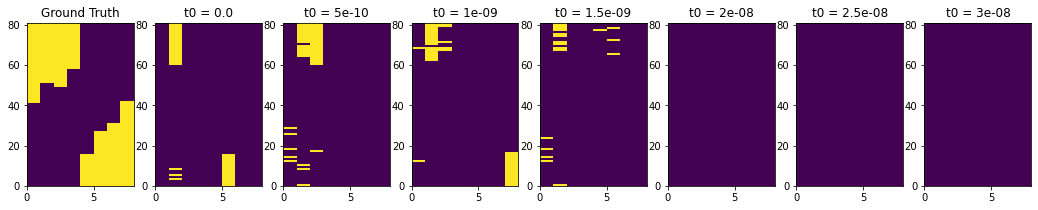

In [8]:
#####################################################################
####### SOLVE INVERSE PROBLEM (RECONSTRUCT VISIBILITY MATRIX) #######
#####################################################################

c = 299792458# 3E8 / 1.0003
# optimization parameters
numIters = 3000
thresh = 1E-100
lr_rate = 0.1
lam = 0 # 5E2 for noiseless case

# object parameters
pixelSize = 0.01 # meters

# plotting parameters
plotData = False
plotError = False
plotSetup = True  
    
# t0s = np.array([6E-9, 7E-9, 8E-9, 9E-9, 1E-8, 1.1E-8, 1.2E-8]) + 14.26E-9 
t0s = np.array([0E-9, 0.5E-9, 1E-9, 1.5E-9, 2E-8, 2.5E-8, 3E-8]) #- 10E-9
# t0s = [0]
i = 0
plt.figure(figsize=(18,3))
plt.xlabel('Spot Number')
plt.ylabel('Pixel Number')
plt.subplot(1, len(t0s)+1, 1)
plt.pcolormesh(vis_gt)
plt.title('Ground Truth')
for t0 in t0s:
    i += 1
    # generate basis functions
    scale = 2965
    tof, hists = generateBasisFunction(albedo, n_vector, pt_loc, las_locs, det_locs, nc, t, t0, pulseShape, bin_width, scale, c, tofs)

    # gradient descent
    m = Model(numPixels, numSpots)
    opt = torch.optim.Adam(m.parameters(), lr=lr_rate)
    # obs_filt = torch.tensor(observations * (observations != 0) / np.max(observations, axis=1))
    # hists_norm = torch.tensor(hists / np.max(hists, axis=2))
    obs_filt = torch.tensor(observations)
    hists_norm = torch.tensor(hists)
    losses = training_loop(m, hists_norm, obs_filt, opt, thresh, lam, n=500)
    vis = m.vis.detach()
    vis = torch.sigmoid(vis)
    v_reconst = torch.where(vis > 0.5, 1, 0).numpy()
    # v_reconst = bruteForce(np.ones((numPixels, numSpots)), hists.detach().numpy(), observations.detach().numpy())

    # plot optimization loss
    if plotError:
        plt.figure(figsize=(14, 7))
        plt.plot(losses)

    # plot visibility matrix
    plt.subplot(1, len(t0s)+1, i+1)
    plt.pcolormesh(v_reconst)
    plt.title('t0 = ' + str(t0))

    # compare ground truth visibility matrix
    # error = np.sum(np.abs(v_reconst-vis_gt))
    # pct_error = 100 * error / (numSpots_y * numPixels_z * numPixels_y)
    # print(str(error) + ' / ' + str(numPixels_z * numPixels_y * numSpots_y) + ' entries in visibility matrix misclassified')
    # print(str(pct_error) + '% of entries in visibility matrix misclassified')

    # onesToZero = np.sum(np.abs(v_reconst-vis_gt) * vis_gt)
    # print(str(onesToZero) + ' ones flipped to zeros')
    # print(str(100 * onesToZero / error) + '% of misclassified entries were ones flipped to zeros')
    # end = timer()
    # print(end - start)

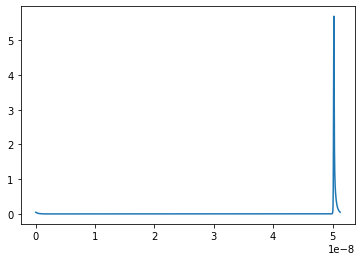

In [9]:
plt.plot(t, hists[0, 3, :])
# plt.plot(t, observations[0, :])
# print(observations.shape)

In [10]:
# import math

# # scale and shift basis functions 
# hists_fft = np.fft.fft(hists) 
# indiv_hists_fft = np.fft.fft(indiv_hists)
# f = np.reshape(np.fft.fftfreq(numBins, bin_width), (1, 1, numBins)) # 1 x 1 x 1 x numBins
# f_tiled = np.tile(f, (numPixels, numSpots, 1))
# proport = indiv_hists_fft / hists_fft
# mag = np.abs(proport)
# mag *= (mag < 1E5)
# scale = np.mean(np.mean(proport, axis=2))

# np.angle(proport[:, :, 1:] / (np.exp(-1j*2*math.pi*f_tiled[:, :, 1:])))
# t0_ests = (math.pi + np.angle(np.fft.fftshift(proport[:, :, 1:]))) / (-1 * 2*math.pi*f_tiled[:, :, 1:])
# t0_ests = t0_ests[:, :, 0:15]
# plt.figure()
# plt.plot(np.squeeze(f), np.real(hists_fft[0, 0, :]))
# print(np.mean(np.mean(mag, axis=2)))
# print(np.mean(np.mean(t0_ests, axis=2)))

In [11]:
# t1, a1 = pulse(0, 64)
# t2, a2 = pulse(1E-9, 64); a2 = 6*a2
# a1_fft = np.fft.fft(a1)
# a2_fft = np.fft.fft(a2)
# f1 = np.fft.fftfreq(64, 100E-12)
# # f1 = np.fft.fftshift(f1)

# plt.figure()
# plt.plot(t1, a1)
# plt.figure()
# plt.plot(f1, np.fft.fftshift(a2_fft) / np.max(a2_fft))
# proport = a2_fft / a1_fft
# mag = np.abs(proport)
# scale = np.mean(mag)

# # print(scale)

# proport = np.fft.fftshift(proport)
# t0_ests = (np.angle(proport[1:])) / (-1 * 2*math.pi*f1[1:])

# print(np.min(t0_ests))
# print(np.max(t0_ests))
# print(np.mean(t0_ests))
# print(t0_ests)
# # plt.figure()
# plt.plot(f1[15:], t0_ests / 1E-9)

In [12]:
# # plt.plot(t, indiv_hists[numPixels-1, 0, :])
# t1 = 0; t2 = 8000
# plt.plot(t[t1:t2], observations[0, t1:t2])
# plt.plot(t[t1:t2], hists[0, 4, t1:t2])

In [13]:
# for i in range(numPixels):
#     for j in range(numSpots):
#         plt.figure()
#         plt.plot(t, hists[i, j, :])
#         plt.plot(t, indiv_hists[i, j, :])

Text(0.5, 1.0, 'Ground Truth')

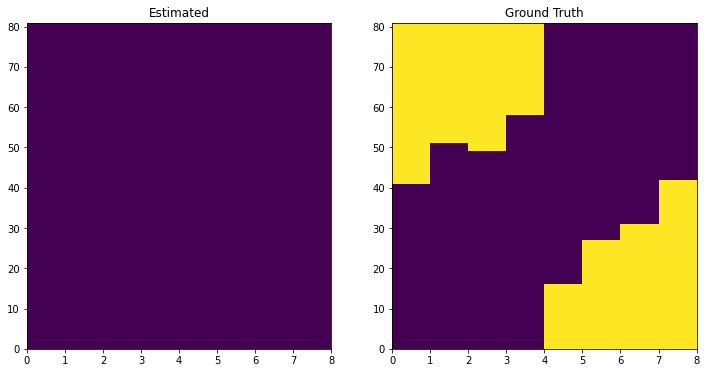

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.pcolormesh(v_reconst)
plt.title('Estimated')
plt.subplot(1, 2, 2)
plt.pcolormesh(vis_gt)
plt.title('Ground Truth')

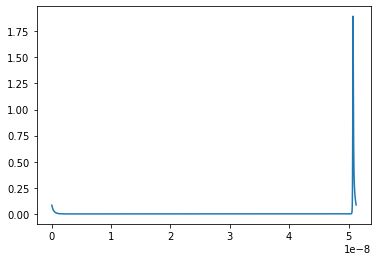

In [15]:
plt.plot(t, hists[0, 0, :])
# plt.plot(t, observations[0, :])

In [16]:
class t0Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        super().__init__()
        # initialize weights with random numbers
        t0 = torch.tensor(1E-8)
        
        # make weights torch parameters
        self.t0 = nn.Parameter(t0, requires_grad=True)      
        
    def forward(self, indiv_hists, pulses_fft, f_tiled):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        numPixels, numSpots, numBins = indiv_hists.shape
        tof = torch.tile(torch.reshape(self.t0, (1, 1, 1)), (numPixels, numSpots, numBins))
        freq_shift = pulses_fft * torch.exp(-1j * 2*math.pi*f_tiled*tof) 
                         
        new_hists = torch.abs(torch.fft.ifft(freq_shift))
        corr = torch.sum(new_hists * indiv_hists)
        return corr

def t0_training_loop(model, indiv_hists, pulses_fft, f_tiled, optimizer, thresh, n=1000):
    "Training loop for torch model."
    losses = []
    prev_loss = 0
    for i in range(n):
        corr = model(indiv_hists, pulses_fft, f_tiled)
        loss = -corr
        cur_loss = loss.detach().numpy()
        losses.append(cur_loss)  
        if np.abs(prev_loss-cur_loss) < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
    return losses

pulses_fft = np.fft.fft(hists)
f = np.reshape(np.fft.fftfreq(numBins, bin_width), (1, 1, numBins))
f_tiled = np.tile(f, (numPixels, numSpots, 1)) 
                         
mt = t0Model()
opt = torch.optim.Adam(mt.parameters(), lr=lr_rate)
losses = t0_training_loop(mt, torch.tensor(indiv_hists), torch.tensor(pulses_fft), torch.tensor(f_tiled), opt, 1E-100, n=500)
t0_guess = mt.t0.detach()

NameError: name 'math' is not defined

In [ ]:
# #####################################################################
# ############################## DEBUG CODE ###########################
# #####################################################################

# # Time Domain
# t_val = t; testPulse = pulseShape; binSize = bin_width
# # t_val, testPulse = pulse(0, 64); binSize = 100E-12
# # binSize = math.pi / 128; t_val = np.linspace(0, 6*math.pi, 769); testPulse = np.cos(2*math.pi*t_val)

# plt.figure()
# plt.subplot(3, 1, 1)
# plt.title('Time Domain')

# plt.plot(t_val, testPulse)

# # Frequency Domain
# pulse_fft = np.fft.fft(np.squeeze(testPulse))
# f = np.fft.fftfreq(len(t_val), binSize)
# plt.figure()
# plt.subplot(3, 1, 2)
# f = np.fft.fftshift(f)
# plt.plot(f, np.fft.fftshift(np.real(pulse_fft)))
# plt.plot(f, np.fft.fftshift(np.imag(pulse_fft)))
# plt.title('Frequency Domain')

# print(pulse_fft.shape)
# print(np.exp(-1j * 2*math.pi*f*0).shape)
# # pulse_fft = pulse_fft * np.exp(-1j * 2*math.pi*f*3E-8)
# # pulseArray = np.tile(np.reshape(pulse_fft, (1, 1, numBins)), (numPixels, numSpots, 1))
# # plt.plot(f, np.fft.fftshift(np.real(pulseArray[i1, i2, :])))
# # plt.plot(f, np.fft.fftshift(np.imag(pulseArray[i1, i2, :])))

# # Inverted 
# inv = np.real(np.fft.ifft(pulse_fft))
# plt.figure()
# plt.subplot(3, 1, 3)
# plt.plot(t_val, inv)
# plt.title('Reconstructed')

# # inv_arr = np.real(np.fft.ifft(pulseArray, axis=-1))
# # plt.plot(t_val, inv_arr[5, 5, :])

In [ ]:
def lossFunction(visGt, visRec, hist, obsGT, lamda):
#     testVar = np.expand_dims(visRec, 3) * hist
#     print(testVar.shape)
#     print(hist.shape)
    obs = np.sum(np.expand_dims(visRec, 3) * hist, 2)
    loss1 = np.mean((obsGT - obs)**2)
    print('Loss 1: ' + str(loss1))
    loss2 = np.sum(np.square(np.diff(visRec, n=1, axis=0)))
    print('Loss 2: ' + str(loss2))
    loss = loss1 + lamda * loss2
    print('Total Loss: ' + str(loss))
    return loss

loss_gt = lossFunction(vis_gt, vis_gt, hists.numpy(), observations.numpy(), lam)
loss_reconst = lossFunction(vis_gt, v_reconst, hists.numpy(), observations.numpy(), lam)

In [ ]:
plt.figure(figsize=(18, 6))
x = np.linspace(1, numSpots, numSpots)
y = np.linspace(1, numPixels, numPixels)

plt.subplot(1, 3, 1)
plt.title('V (Ground Truth)')
plt.xlabel('Source #')
plt.ylabel('Pixel #')
plt.contourf(x, y, vis_gt)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('V (Reconstructed)')
plt.xlabel('Source #')
plt.ylabel('Pixel #')
plt.contourf(x, y, v_reconst)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Error in Visibility Matrix (vis_gt - v_reconst)')
vis_errors = vis_gt - v_reconst
plt.xlabel('Source #')
plt.ylabel('Pixel #')
plt.contourf(x, y, vis_errors)
plt.colorbar()

In [ ]:
# plot for all entries
a = np.sum(vis_gt, 1)
b = np.sum(v_reconst, 1)
min_err = min(np.min(a), np.min(b))
max_err = max(np.max(a), np.max(b))
x = np.linspace(min_err, max_err); y = x
plt.figure()
plt.plot(a, b, 'o')
plt.plot(x, y, 'r')
plt.legend(['experimental', 'ideal'])
plt.xlabel('# of "on" sources (GT)')
plt.ylabel('# of "on" sources (estimated)')
plt.title('Comparison of # of "on" sources')
print(np.abs(a-b) * (np.abs(a-b) > 5))

In [ ]:
#####################################################################
#################### COMPUTE SHAPE USING CARVING ####################
#####################################################################

# carving parameters
pixelSize = 0.02# in meters
xMin = -1.25; xMax = 1.25
eta = 0.01; zeta = 0.85; p_e = 0.5; p_o = 0.5

# compute and plot heatmap
xlocs, ylocs, heatmap, naiveMap, occupied_prob, unoccupied_prob = carving(v_reconst, las_x, las_y, det_x, det_y, 
                                                                          pixelSize, xMin, xMax, eta, zeta, p_e, p_o)
heatmap_mod = heatmap * ((unoccupied_prob != 0 )| (occupied_prob != 0))

plt.figure(figsize=(6,6))
plt.title('Probabilistic Space Carving')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.contourf(xlocs, ylocs, heatmap_mod)
plt.plot(np.linspace(x_min, x_max, 100), y_min * np.ones(100), 'r')
plt.plot(np.linspace(x_min, x_max, 100), y_max * np.ones(100), 'r')
plt.plot(x_max*np.ones(100), np.linspace(y_min, y_max, 100), 'r')
plt.plot(x_min*np.ones(100), np.linspace(y_min, y_max, 100), 'r')
plt.legend(['Ground Truth'])
plt.colorbar()

plt.figure(figsize=(6,6))
plt.title('Naive Space Carving')
# plt.gray()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.contourf(xlocs, ylocs, naiveMap)
plt.plot(np.linspace(x_min, x_max, 100), y_min * np.ones(100), 'r')
plt.plot(np.linspace(x_min, x_max, 100), y_max * np.ones(100), 'r')
plt.plot(x_max*np.ones(100), np.linspace(y_min, y_max, 100), 'r')
plt.plot(x_min*np.ones(100), np.linspace(y_min, y_max, 100), 'r')
plt.legend(['Ground Truth'])
plt.colorbar()

plt.figure(figsize=(6,6))
plt.title('Unoccupied Probability')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.contourf(xlocs, ylocs, unoccupied_prob)
plt.plot(np.linspace(x_min, x_max, 100), y_min * np.ones(100), 'r')
plt.plot(np.linspace(x_min, x_max, 100), y_max * np.ones(100), 'r')
plt.plot(x_max*np.ones(100), np.linspace(y_min, y_max, 100), 'r')
plt.plot(x_min*np.ones(100), np.linspace(y_min, y_max, 100), 'r')
plt.legend(['Ground Truth'])
plt.colorbar()

plt.figure(figsize=(6,6))
plt.title('Occupied Probability')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.contourf(xlocs, ylocs, occupied_prob)
plt.plot(np.linspace(x_min, x_max, 100), y_min * np.ones(100), 'r')
plt.plot(np.linspace(x_min, x_max, 100), y_max * np.ones(100), 'r')
plt.plot(x_max*np.ones(100), np.linspace(y_min, y_max, 100), 'r')
plt.plot(x_min*np.ones(100), np.linspace(y_min, y_max, 100), 'r')
plt.legend(['Ground Truth'])
plt.colorbar()